# **Imports**

In [53]:
%%capture
!pip install -q lime shap

In [54]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
import kagglehub
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc, PrecisionRecallDisplay
from sklearn.inspection import PartialDependenceDisplay,permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import textwrap
import lime
from scipy import stats
import lime.lime_tabular
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc, roc_curve
import warnings
warnings.filterwarnings('ignore')

# **Utils**

In [55]:
def our_confusion_matrix(model, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(
    model, X_train, y_train,
    name=name, ax=ax1,
    color="orange"
    )
    roc2 = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name, ax=ax2,
        color="orange"
    )
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )

    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')

## **Check LDA Assumption**

##  **Homoscedasticity**

In [78]:
def check_homoscedasticity(y_pred, residuals, ylim=(-10, 10), xlim=(0, 26)):

    p = sns.scatterplot(x=y_pred, y=residuals)
    plt.xlabel('y_pred / predicted values')
    plt.ylabel('Residuals')
    plt.ylim(ylim)
    plt.xlim(xlim)
    p = sns.lineplot(x=[xlim[0], xlim[1]], y=[0, 0], color='blue')
    p = plt.title('Homoscedasticity Check')
    return p

## Mean of Residuals

In [57]:
def  mean_of_residuals(residuals):
    return np.mean(residuals)

## Multicollinearity

In [58]:
def check_multicollinearity(features, vif_threshold=10):
    vif = pd.Series(
        [variance_inflation_factor(features.values, i)
         for i in range(features.shape[1])],
        index=features.columns
    )
    return list(vif[vif > vif_threshold].index)

# **Load Processed Data**

In [59]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,promotion_velocity,workload_score,compensation_ratio,Attrition,Set
0,31,2,1062,1,24,3,3,3,0,96,...,3,10.0,9,1,8,9.999900,1,1.019760,0,Train
1,50,2,328,1,1,3,3,3,1,86,...,2,3.0,2,0,2,300000.000000,2,1.281918,0,Train
2,46,2,717,1,13,4,1,3,1,34,...,3,10.0,7,0,9,1000000.000000,1,0.832635,0,Train
3,44,2,170,1,1,4,1,2,1,78,...,3,2.0,0,2,2,0.999995,1,0.753443,0,Train
4,26,1,1479,1,1,3,1,3,0,84,...,1,6.0,5,1,4,5.999940,3,1.007878,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,56,2,1162,1,24,2,1,1,1,97,...,3,4.0,2,1,0,3.999960,1,0.898732,1,Test
2043,46,2,669,2,9,2,3,3,1,64,...,3,9.0,8,4,7,2.249994,1,1.558490,1,Test
2044,30,2,1240,0,9,3,0,3,1,48,...,1,11.0,9,4,7,2.749993,7,2.052053,0,Test
2045,31,2,741,1,2,4,1,2,1,69,...,4,5.0,2,0,3,500000.000000,0,1.207921,0,Test


In [60]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


# **Model Initialization**

In [61]:
lda_classifier = LinearDiscriminantAnalysis()

# **Model Training**

In [62]:
lda_classifier.fit(X_train, y_train)

LinearDiscriminantAnalysis()

# **Model Evaluation**

In [63]:
y_pred = lda_classifier.predict(X_test)
y_pred_proba = lda_classifier.predict_proba(X_test)[:, 1]

In [64]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7664


In [65]:
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition'])
print(report)

Classification Report:
              precision    recall  f1-score   support

No Attrition       0.88      0.83      0.85       373
   Attrition       0.40      0.49      0.44        85

    accuracy                           0.77       458
   macro avg       0.64      0.66      0.65       458
weighted avg       0.79      0.77      0.78       458



> The model shows weak recall (0.49) for "Attrition", meaning it misses 51% of actual attrition cases.

> The model accuray is 77%

> The F1-score of 0.44 for Attrition shows that the model is useless. Random guessing would perform similarly without the development effort.


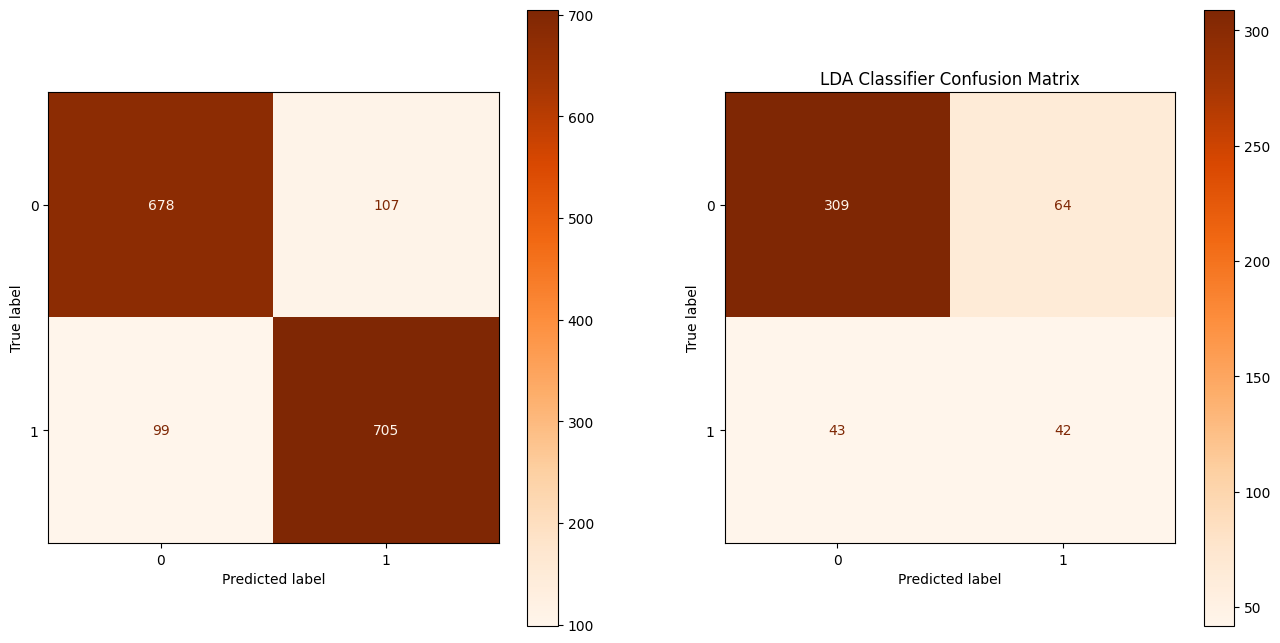

In [66]:
our_confusion_matrix(lda_classifier, name="LDA Classifier")
plt.savefig('Confusion Matrix - LDA.jpg')

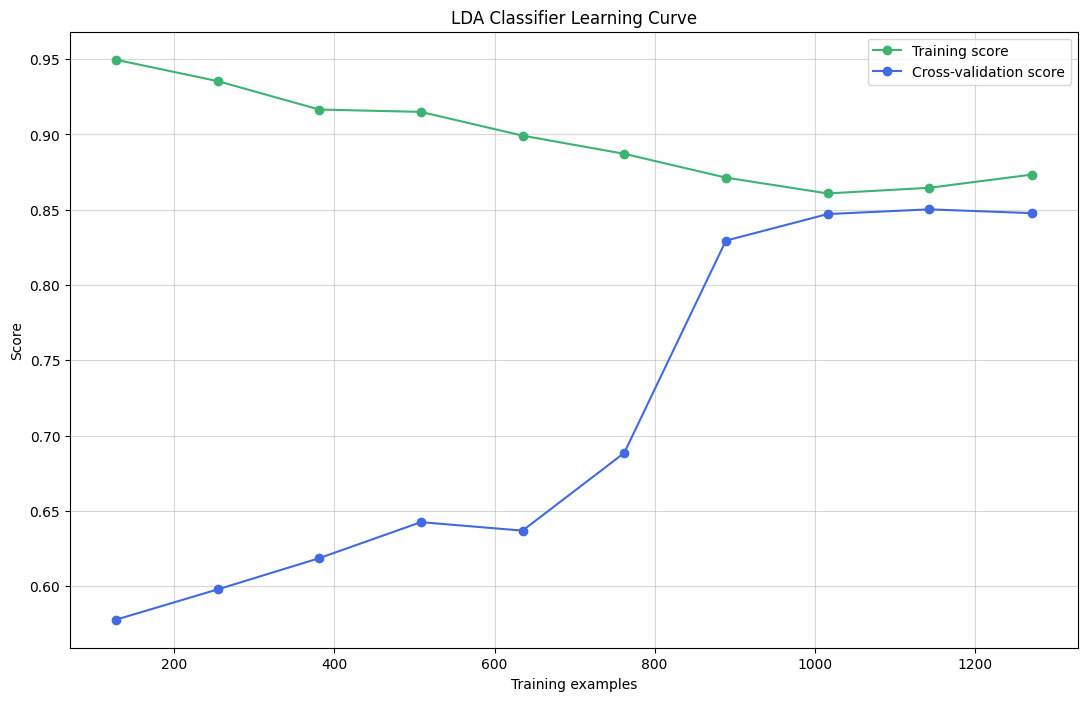

In [67]:
our_learning_curve(lda_classifier, name="LDA Classifier")
plt.savefig('Learning Curve - LDA.jpg')

> The learning curve shows that the model started with high training score as their was a few samples so it was overfitted. The score droppoed slightly suggesting that the model start to generalize instead of remebering the noise.

> The cross validation curve starts at a low score indicating under sampling (the model still didn't learn the data). The score starts increasing with a big jump between 800 and 900 (suggesting a threshold).

> The gap between the training and validation is narrowed suggesting that the model is learning with more data samples

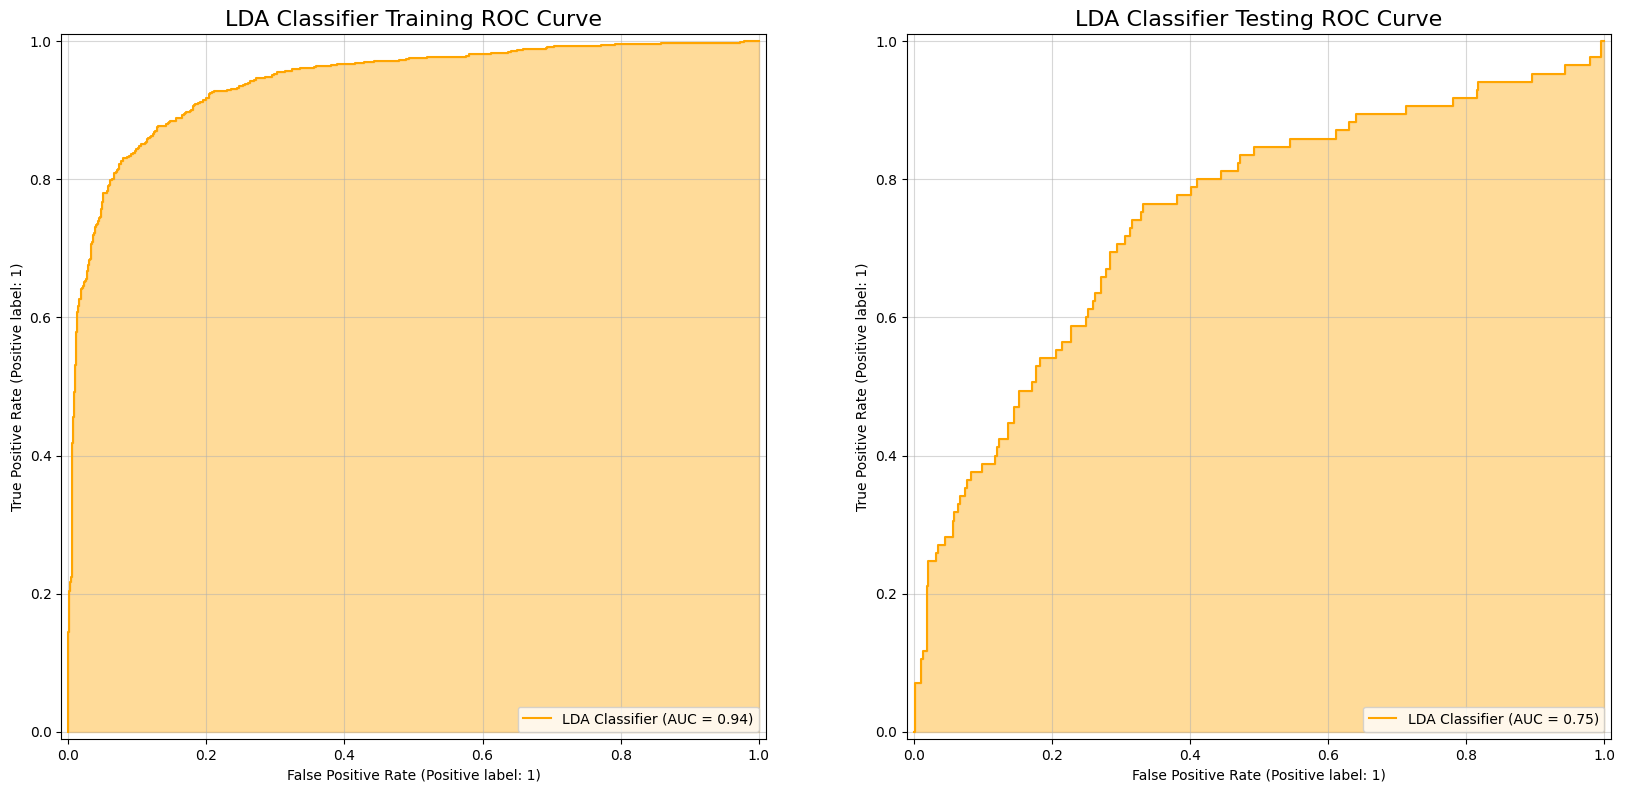

In [84]:
our_roc(lda_classifier, name="LDA Classifier")
plt.savefig('ROC Train&Test- LDA.jpg')

> The model performed well at distinguishing the positive class in the training data with high AUC (0.94).

>In the testing phase the performace dropped siginfactly to be (0.75), indicating the model struggles to generalize the unseen data.

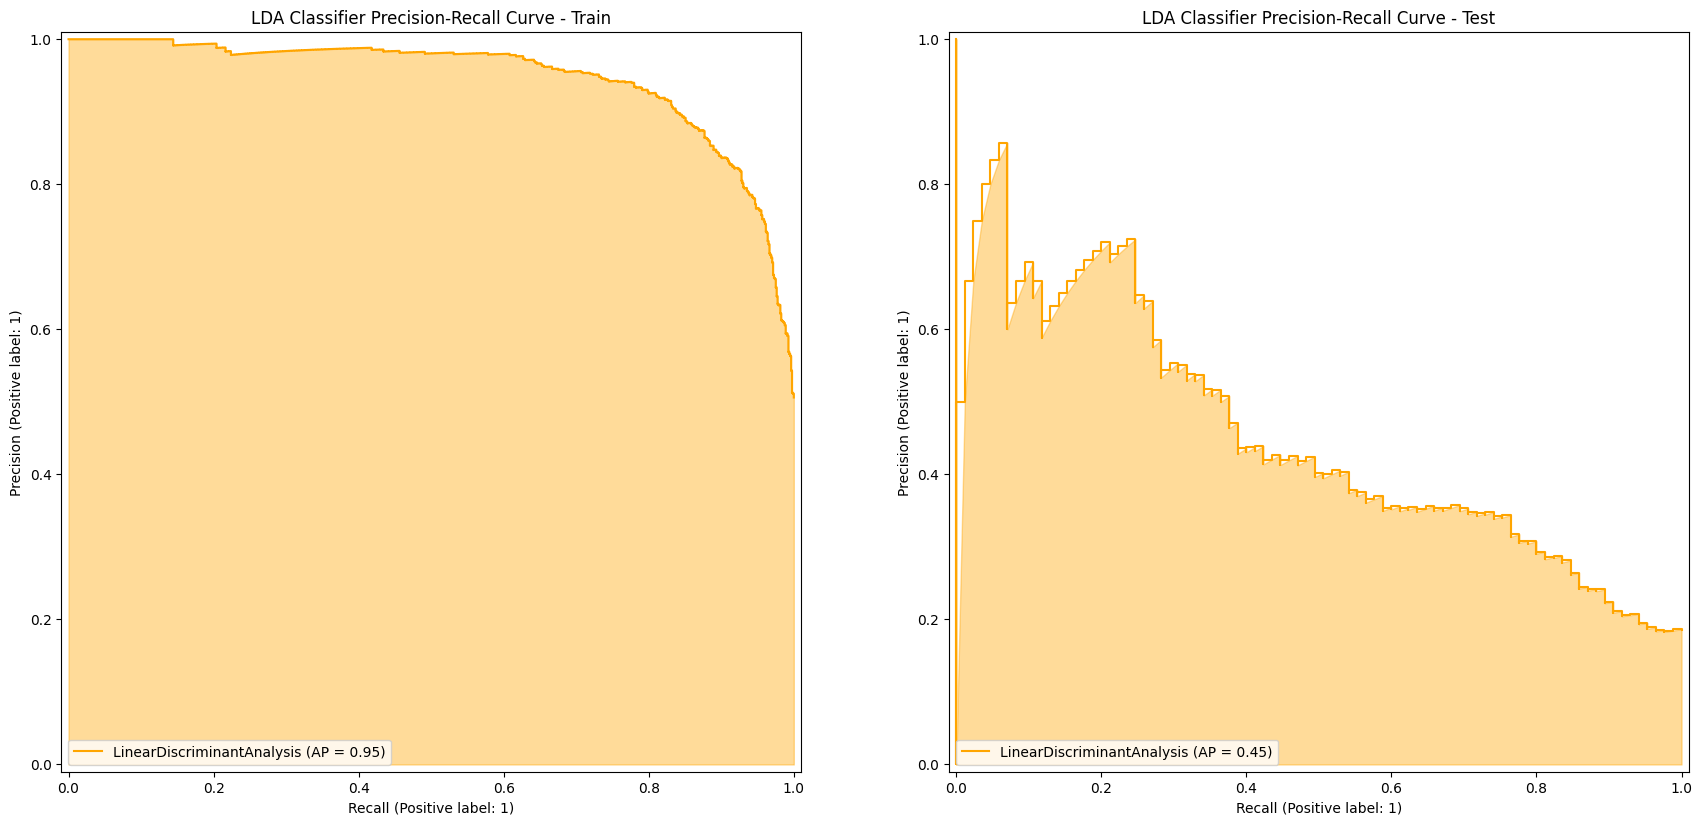

In [68]:
our_prc(lda_classifier, name="LDA Classifier")
plt.savefig('Percision&Recall Train&Test - LDA.jpg')

> Initially, the training precision-recall curve shows very high performance, with average precision equal to 0.95.

> However, the test precision-recall curve performs significantly worse, starting high but dropping quickly and showing an average precision of only around 0.45.

> The large drop in performance from training to testing indicates that the model is overfitting to the training data.

> The difference between the two curves suggests that the model struggles to generalize well on unseen data.



##**Check Assumptions**

###**Check Normality**

In [69]:
residuals = y_pred - y_test

Text(0.5, 1.0, 'Homoscedasticity Check')

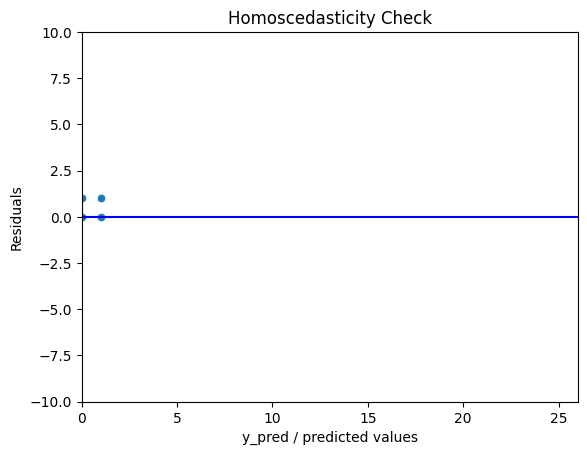

In [79]:
check_homoscedasticity(y_test, y_pred)

###**Mean of Residuals**

In [71]:
print(mean_of_residuals(residuals))

0.04585152838427948




> The mean of the residulas is close to zero. Everything is good here



##**Check Multicollinearity**

In [72]:
high_vif = check_multicollinearity(X_train, vif_threshold=10)
print("High-VIF features:", high_vif)

High-VIF features: ['Age', 'Department', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'MonthlyIncome', 'PercentSalaryHike', 'PerformanceRating', 'TotalWorkingYears', 'WorkLifeBalance', 'YearsAtCompany', 'workload_score', 'compensation_ratio']


## LIME Analysis

In [73]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No Attrition', 'Attrition'],
    mode='classification'
)

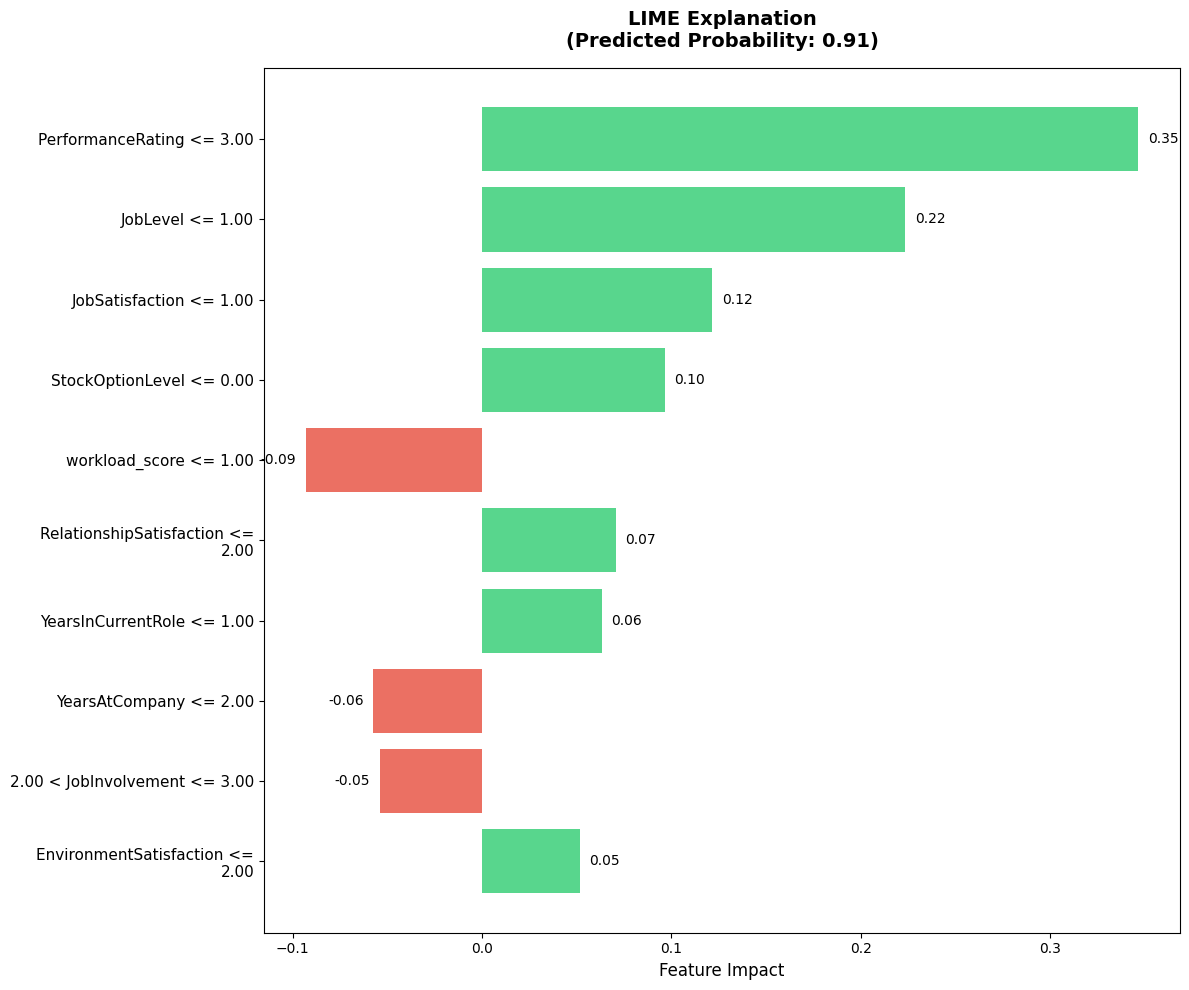

In [74]:
instance = X_test.iloc[0]
pred_prob = lda_classifier.predict_proba([instance])[0][1]
exp = explainer.explain_instance(instance.values, lda_classifier.predict_proba, num_features=10)

values = [v for _, v in exp.as_list(label=1)]
features = [f for f, _ in exp.as_list(label=1)]
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in values]

wrapped_features = [textwrap.fill(f, width=30) for f in features]

fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(wrapped_features))
bars = ax.barh(y_pos, values, color=colors, alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(wrapped_features, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Feature Impact', fontsize=12)
ax.set_title(f'LIME Explanation\n(Predicted Probability: {pred_prob:.2f})', fontsize=14, weight='bold', pad=15)

for i, v in enumerate(values):
    ax.text(v + 0.005 if v > 0 else v - 0.005, i, f"{v:.2f}",
            va='center', ha='left' if v > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig('LIME - LDA Classifier.jpg')
plt.close()

> **The 91% is the Attrition risk.**

> Green bars are the features that increase the chance of leaving, While red bars decreases it.

> Performance Rating (≤ 3.00) has the most impact for employee to leave. JobLevel (≤ 1.00) and JobSatisfaction (≤ 1.00) are also strong flags to push the employee toward leaving the compnay.

> workload_score (≤ 81.00002) and YearsAtCompany (≤2.00) decrease the probability of leaving. The same intepretation with the other columns.

## SHAP Analysis

  0%|          | 0/100 [00:00<?, ?it/s]

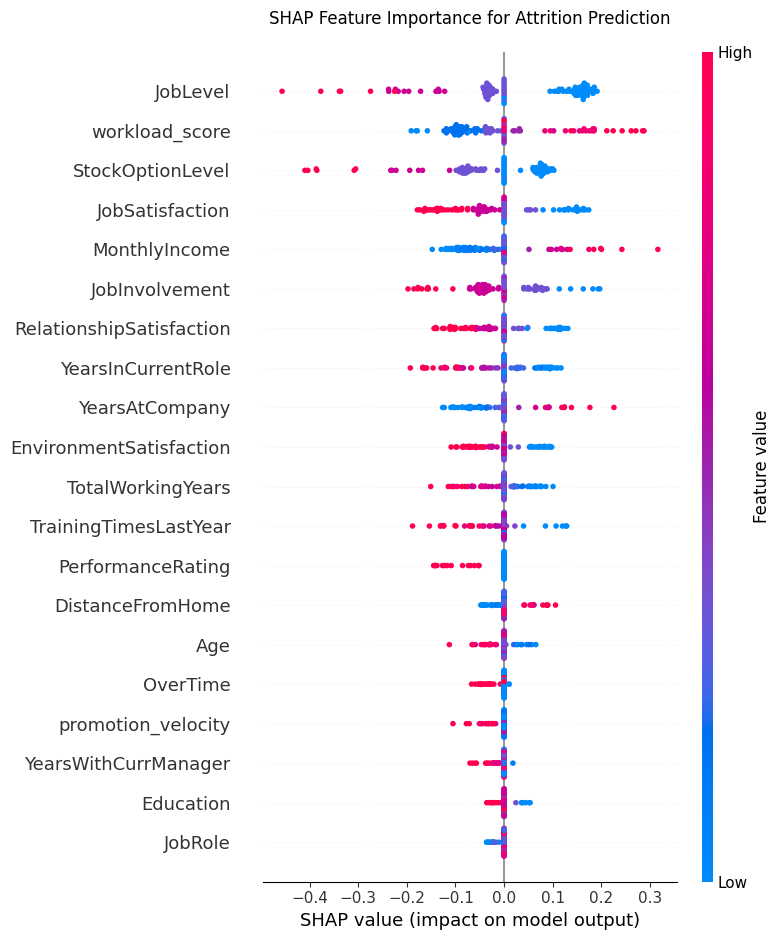

<Figure size 640x480 with 0 Axes>

In [75]:
explainer = shap.KernelExplainer(lda_classifier.predict_proba, shap.sample(X_train, 100))
sample_size = min(100, len(X_test))
X_sample = X_test.iloc[:sample_size]

shap_values = explainer.shap_values(X_sample)

if len(np.array(shap_values).shape) == 3:
    shap_values_attrition = shap_values[:,:,1]
elif len(np.array(shap_values).shape) == 2:
    shap_values_attrition = shap_values

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_attrition,
    X_sample,
    feature_names=X_train.columns.tolist(),
    plot_type="dot",
    show=False
)
plt.title("SHAP Feature Importance for Attrition Prediction", pad=20)
plt.tight_layout()
plt.show()
plt.savefig('SHAP - LDA.jpg')

> Each dot represent a person, and color show if their value for this feature is high (red) or low (blue).

> JobLevel is the most infulential factor, people with low job level (blue dots) are more likely to leave, while those with high job level (red dots) are more likely to stay.

> On the other hand, Education and JobRole have a smaller impact. The spread of dots is narrow, meaning that these features doesn't strongly push the prediction toward staying or leaving.

## Partial Dependence Plots

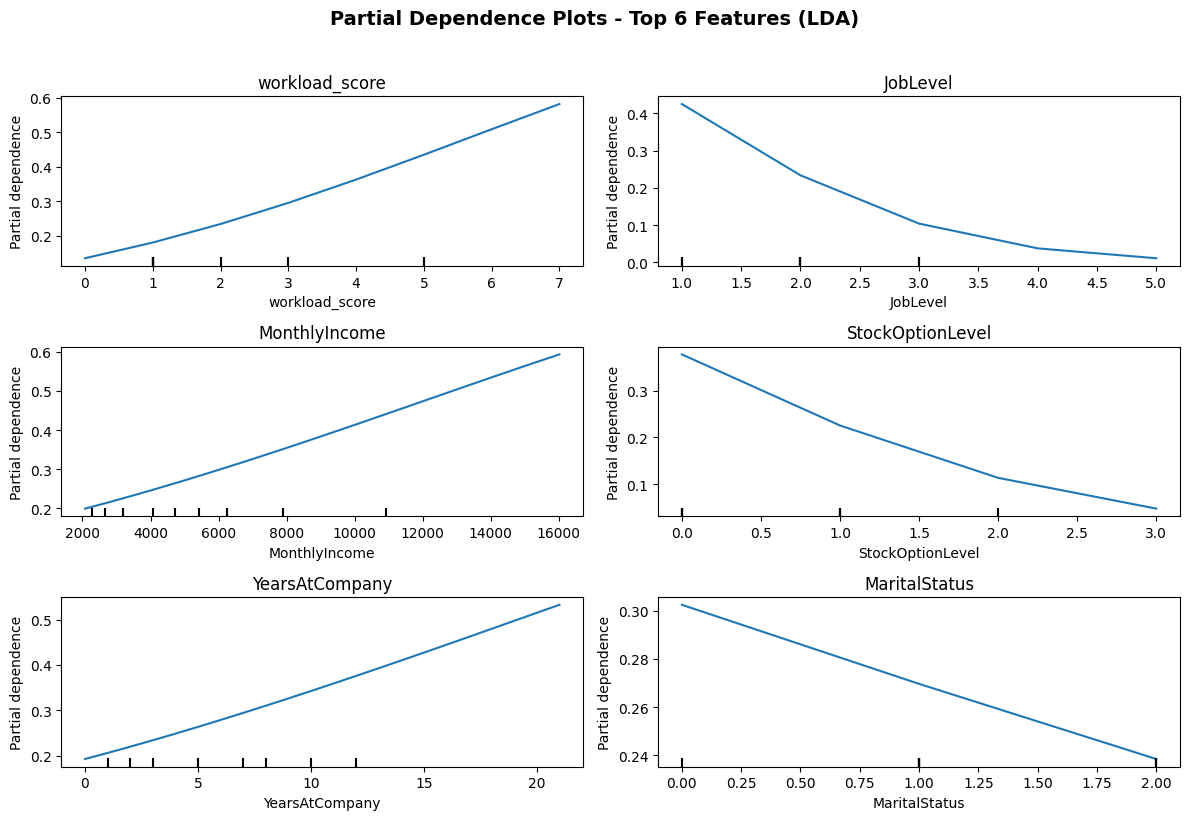

In [81]:
perm = permutation_importance(lda_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

top6 = X_train.columns[perm.importances_mean.argsort()][-6:][::-1]

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, feature in zip(axes, top6):
    PartialDependenceDisplay.from_estimator(lda_classifier, X_test, [feature], ax=ax)
    ax.set_title(feature)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Partial Dependence Plots - Top 6 Features (LDA)", y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig('PDP - LDA.jpg')
plt.close()

> The PDP graph shows how different features influnces the target variable. The strongest feature is the workload_score which increased from 0.2 to 0.6, indicatingg that higher workload_score increases the likelihood of attrition.

> On the other hand, the MaritalStatus PDP decreases from ~0.3 to ~0.24. This indicates that lower MaritalStatus slightly decreases the likelihood of attrition. The effect is very small, and doesn't impact too much.

## Permutation Feature Importance

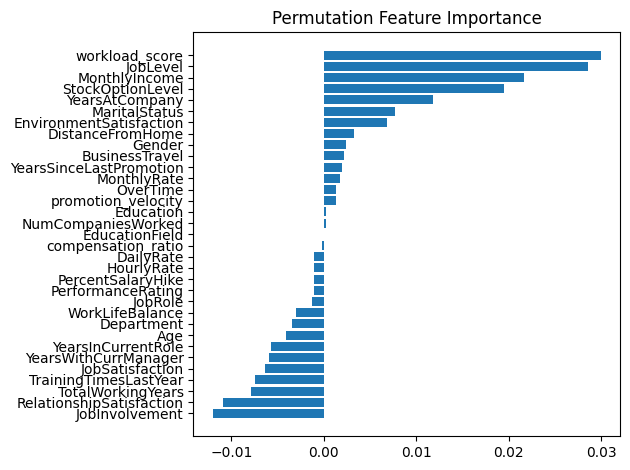

In [82]:
result = permutation_importance(
    lda_classifier,
    X_test[X_train.columns],
    y_test,
    n_repeats=10,
    random_state=42
)

sorted_idx = result.importances_mean.argsort()

plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()
plt.savefig('PFI - LDA.jpg')
plt.close()

> Top featuers like workload_score, JobLevel and MonthlyIncome are the most effective featues in taking this decision.

> On the other hand feature like JobInvolvement and Relationship Satisfaction suggests that the model relies on them but incorrectly.

> Feature like NumComaniesWorked, has no impact (They are likely noise) at least that what this method tells us.